In [19]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import LTransform as LT
import numpy as np
import matplotlib.pyplot as plt

In [27]:
model_num = 1
phase = 'NF1'

model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='finetune7')
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

In [25]:
from utils import calculate_lateral_deviation
from scipy.optimize import minimize

def lat_loss(theta):
    data = test(cfg_file,weight_file,ff_coefficient=0,is_channel=True,K=np.exp(theta[0]),B=-np.exp(theta[1]))
    _, _, _, opt = calculate_lateral_deviation(data['xy'], data['tg'], data['vel'])
    return np.mean(opt['max_lateral_dev'])

# find K and B such that max lateral deviation is minimized...
loss_before = lat_loss([-np.inf , -np.inf])

theta0 = [5,2]
theta = minimize(lat_loss,theta0,method='Nelder-Mead',options={'maxiter':10000,'disp':False})
loss_after = lat_loss(theta.x)

print(f'loss before: {loss_before}')
print(f'loss after: {loss_after}')
print(np.exp(theta.x))

#fig, ax  = plot.plot_simulations(xy=xy,target_xy=tg, vel=vel,figsize=(8,6))

loss before: 0.03250525891780853
loss after: 0.0035023665986955166
[182.08442774   0.99138812]


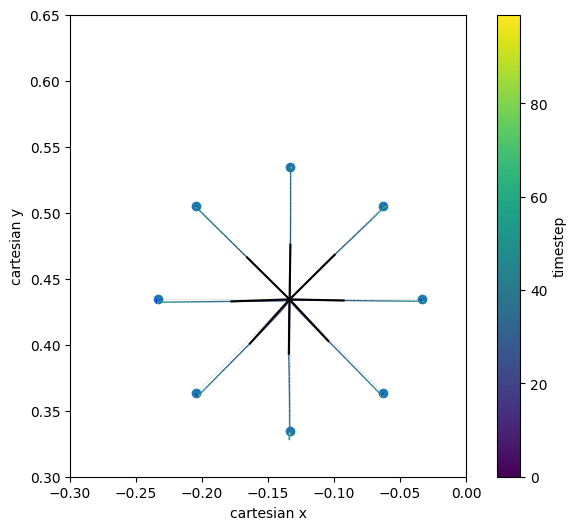

In [28]:

#%matplotlib widget
#%matplotlib qt
#%matplotlib inline
K=182.08442774
B=-0.99138812
data = test(cfg_file,weight_file,ff_coefficient=0,is_channel=True,K=K,B=B)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'], vel=data['vel'],figsize=(8,6))

(<Figure size 1000x1000 with 8 Axes>,
 array([<Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>,
        <Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>,
        <Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>,
        <Axes: ylabel='hidden act (au)'>, <Axes: ylabel='hidden act (au)'>],
       dtype=object))

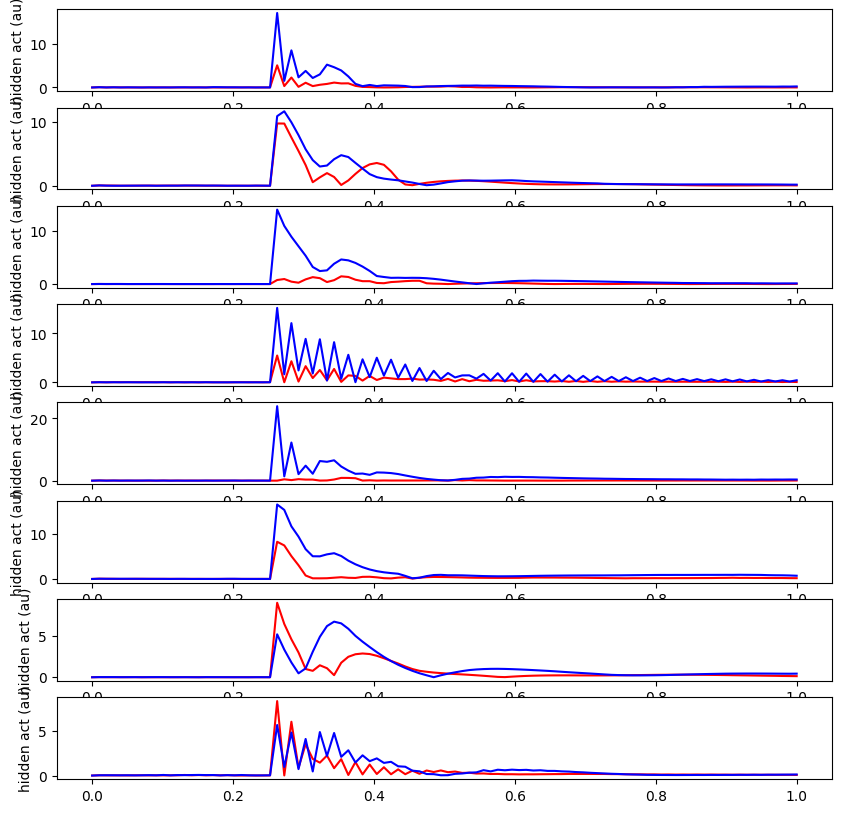

In [33]:
plt.plot_force(endpoint1,endpoint2)

In [15]:
model_num = 1
phase = 'FF1'
directory_name = 'finetune7'

model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name=directory_name)
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

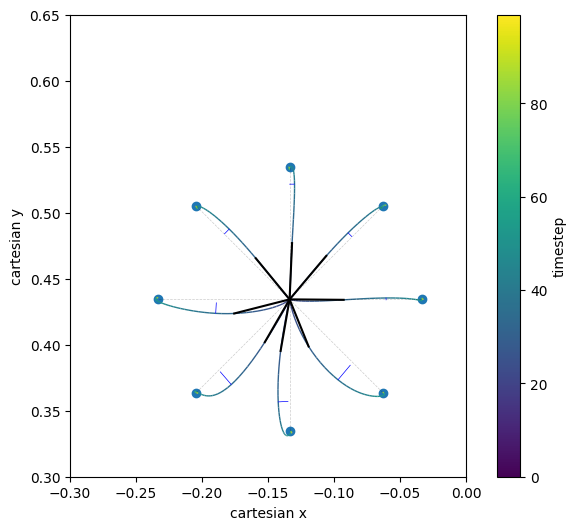

In [13]:
data = test(cfg_file,weight_file,ff_coefficient=0,is_channel=False)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'],vel=data['vel'],plot_lat=True)

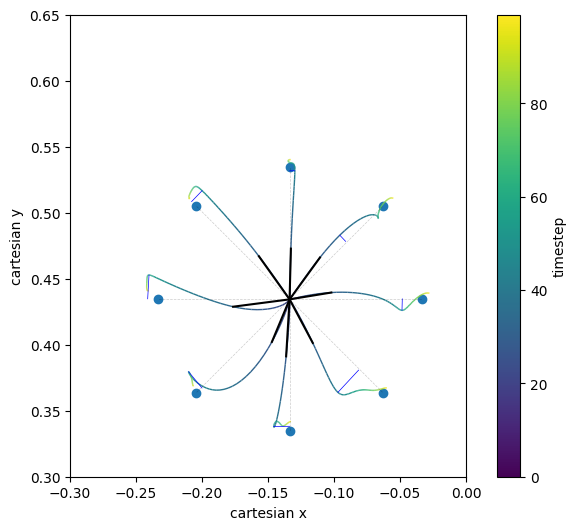

In [16]:
data = test(cfg_file,weight_file,ff_coefficient=8,is_channel=False)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'],vel=data['vel'],plot_lat=True)

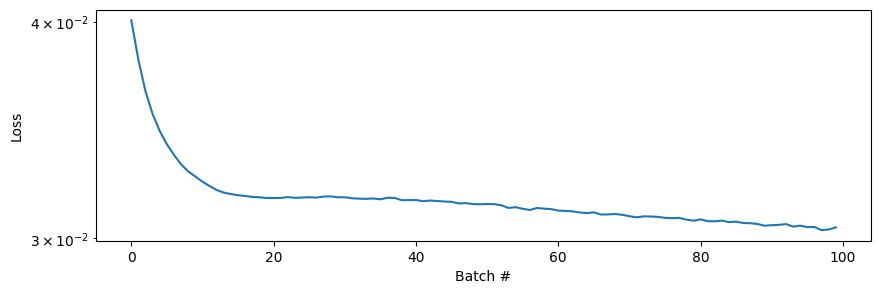

In [17]:
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log=log,loss_type='position')

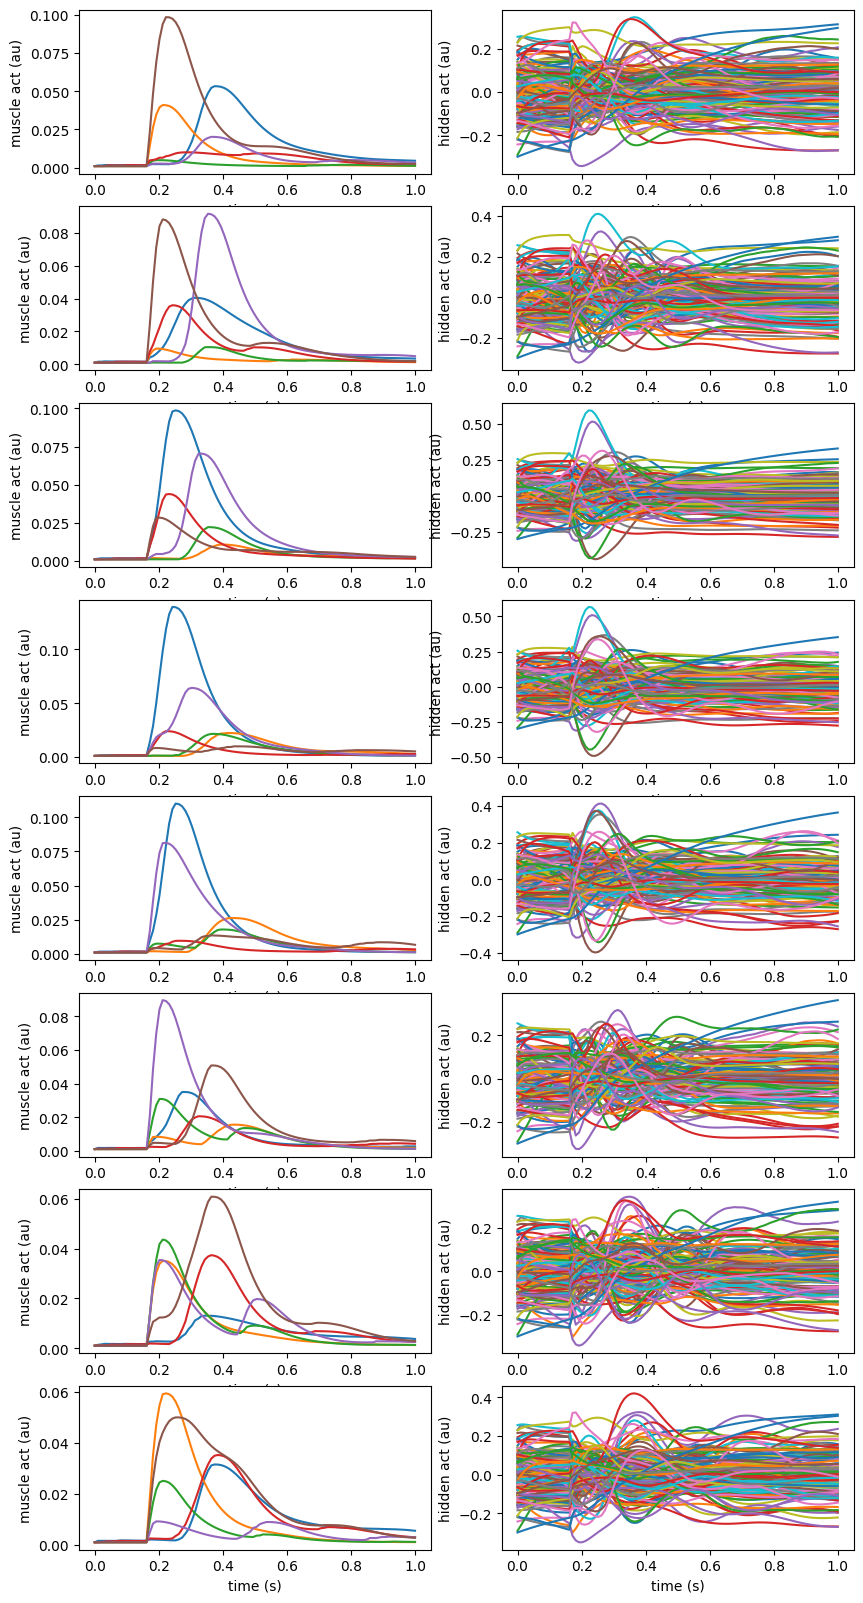

In [18]:
fig, ax = plot.plot_activation(data['all_hidden'],data['all_muscle'])
#fig.savefig(os.path.join(data_dir,'activations.png'),dpi=300)